# Assignment2

2021021581 임진하<br>
2021021699 이유원<br>
2021011207 박지훈

In [1]:
import numpy as np
import seaborn as sb
import pandas
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.linear_model import LinearRegression
import torch
import time
import random

# Part1


In [2]:
def relu(X):
    return np.maximum(X, 0)

def relu_derivative(X):
    return 1. * (X>0)

def tanh(X):
    return np.tanh(X)

def tanh_derivative(X):
    return (1. -tanh(X)**2)

def logistic(X):
    return (1.0/(1.0 + np.exp(-X)))

def logistic_derivative(X):
    return (logistic(X) * (1.0-logistic(X)))

def actv_func(X):
    return 

#### Derivatives of activation funcions
##### ReLU
$f' = \begin{cases}
        1 & if \quad x>0\\
        0 & otherwise
        \end{cases}$

##### logistic
$f'(x) = f(x)(1-f(x))$

##### tanh
$f'(x)=1-f(x)^2$

In [3]:
# create a multi-layer neural network
def create_model(X, hidden_nodes, output_dim=2, activation_function = "relu", hidden_layers_num = 2):
    
    # check if the input of hidden nodes length mathes the number of hidden layers
    assert len(hidden_nodes) == (hidden_layers_num-1), \
        "Number of hidden nodes should be equal to number of hidden layers"
    
    # this will hold a dictionary of layers
    model = {}
    model['activation_function'] = activation_function
    # input dimensionality
    input_dim = X.shape[1]

    weight = {}
    bias = {}

    # initialize the weights and bias
    for i in range(hidden_layers_num):
        # the first layer should be the input dimensionality
        if i == 0:
            weight[i] = np.random.randn(input_dim, hidden_nodes[i])
            bias[i] = np.zeros((1,hidden_nodes[i]))
        # the last layer should be the output dimensionality
        elif i == hidden_layers_num-1:
            weight[i] = np.random.randn(hidden_nodes[i-1], output_dim)
            bias[i] = np.zeros((1,output_dim))
        
        else:
            weight[i] = np.random.randn(hidden_nodes[i-1], hidden_nodes[i])
            bias[i] = np.zeros((1,hidden_nodes[i]))
    
    model['weight'] = weight
    model['bias'] = bias

    return model

In [4]:
# create a forward pass for multi layer neural network
def forward(model, x, activation_function = "relu", hidden_layers_num = 2):
    # this will hold the activation values
    activations = {}
    activations[0] = x

    # number of layers in the model
    L = hidden_layers_num + 1

    # perform the forward pass
    for i in range(1, L):
        if i == L-1:
            activations[i] = np.dot(activations[i-1], model['weight'][i-1]) + model['bias'][i-1]
        else:
            if activation_function == "relu":
                activations[i] = relu(np.dot(activations[i-1], model['weight'][i-1]) + model['bias'][i-1])
            elif activation_function == "tanh":
                activations[i] = tanh(np.dot(activations[i-1], model['weight'][i-1]) + model['bias'][i-1])
            elif activation_function == "logistic":
                activations[i] = logistic(np.dot(activations[i-1], model['weight'][i-1]) + model['bias'][i-1])
            else:
                print("Please enter a valid activation function")
                sys.exit()
    
    return activations

In [5]:
# create a function for calculatin multi layer regression loss
def loss(model, x, y, activation_function = "relu", hidden_layers_num = 2):
    # get the number of examples
    m = x.shape[0]
    # perform the forward pass
    activations = forward(model, x, activation_function, hidden_layers_num)
    # number of layers in the model
    L = hidden_layers_num + 1
    # get the last activation
    yhat = activations[L-1]
    # calculate the loss
    loss = np.sum((yhat - y)**2) / (2*m)
    
    return loss

In [6]:
# create a function for calculating multi layer regression loss with l2 regularization
def calculate_loss(model, x, y, activation_function = "relu", hidden_layers_num = 2, reg_lambda = 0.01, regularization=False):
    # number of layers in the model
    L = hidden_layers_num + 1
    
    # number of training samples
    m = x.shape[0]
    
    # forward pass
    activations = forward(model, x, activation_function, hidden_layers_num)
    
    if regularization:
        # calculate the loss
        loss = 0.5 * np.sum((activations[L-1] - y)**2)/m
        
        # add regularization term to loss (optional)
        for i in range(L-1):
            loss += 0.5 * reg_lambda * np.sum(model['weight'][i]**2)

    else:
        # calculate the loss
        loss = 0.5 * np.sum((activations[L-1] - y)**2)/m
    
    return loss

In [7]:
# create a function for backpropagation for multi layer neural network with l2 regularization
def backward(model, x, y, activations, activation_function = "relu", hidden_layers_num = 2, reg_lambda = 0.01, regularization = False):
    # number of layers in the model
    L = hidden_layers_num + 1
    
    # number of training samples
    m = x.shape[0]
    
    # backward pass
    # first, calculate the gradient at the output layer
    grad = {}
    grad[L-1] = (activations[L-1] - y)/m
    
    # next, calculate the gradient for the rest of the layers
    for i in range(L-2, 0, -1):
        if activation_function == "relu":
            grad[i] = np.dot(grad[i+1], model['weight'][i].T) * relu_derivative(activations[i])
        elif activation_function == "tanh":
            grad[i] = np.dot(grad[i+1], model['weight'][i].T) * tanh_derivative(activations[i])
        elif activation_function == "logistic":
            grad[i] = np.dot(grad[i+1], model['weight'][i].T) * logistic_derivative(activations[i])
        else:
            print("Please enter a valid activation function")
            sys.exit()
    
    # calculate the gradient for the weights and bias
    grad_weight = {}
    grad_bias = {}

    # calcuate with regularizaition with lambda that is given
    if regularization:
        for i in range(L-1):
            if i == 0:
                grad_weight[i] = np.dot(x.T, grad[i+1]) + reg_lambda * model['weight'][i]
                grad_bias[i] = np.sum(grad[i+1], axis=0, keepdims=True)
            else:
                grad_weight[i] = np.dot(activations[i].T, grad[i+1]) + reg_lambda * model['weight'][i]
                grad_bias[i] = np.sum(grad[i+1], axis=0, keepdims=True)
    # calculate without regularization
    else:
        for i in range(L-1):
            if i == 0:
                grad_weight[i] = np.dot(x.T, grad[i+1])
                grad_bias[i] = np.sum(grad[i+1], axis=0, keepdims=True)
            else:
                grad_weight[i] = np.dot(activations[i].T, grad[i+1])
                grad_bias[i] = np.sum(grad[i+1], axis=0, keepdims=True)
    
    return grad_weight, grad_bias

In [8]:
# create a function for training the multi layer neural network
def train(model, x, y, learning_rate = 0.01, activation_function = "relu", hidden_layers_num = 2, reg_lambda = 0.01, epochs = 10000, sgd = True, regularization=True):
    # number of layers in the model
    L = hidden_layers_num + 1

    previous_loss = float('inf')
    losses = []

    current_iter = 0
    
    # gradient descent
    for i in range(epochs):
        if sgd:
            # choose a random set of points
            randinds = np.random.choice(np.arange(len(y)),30,False)
            input_data = x[randinds,:]
            target = y[randinds]
        else:
            input_data = x
            target = y
        # forward pass
        activations = forward(model, input_data, activation_function, hidden_layers_num)
        # backward pass
        grad_weight, grad_bias = backward(model, input_data, target, activations, activation_function, hidden_layers_num, reg_lambda, regularization=regularization)
        
        # update the weights and bias
        for j in range(L-1):
            model['weight'][j] -= learning_rate * grad_weight[j]
            model['bias'][j] -= learning_rate * grad_bias[j]

        if i % 1000 == 0:
            # calculate the loss
            loss = calculate_loss(model, x, y, activation_function, hidden_layers_num, reg_lambda, regularization=regularization)
            losses.append(loss)
            # print("Loss after iteration %i: %f" %(i, loss))
            # very crude method to break optimization
            if np.abs((previous_loss-loss)/previous_loss) < 0.0001:
                break
            previous_loss = loss
        
        current_iter += 1

    current_iter += 1
    
    return model, losses, current_iter

Loss for regression is usaully defined  as **Mean Squared Error**  denoted as MSE. It is error between the prediction value and the target value.<br>
So it could be solving the optimizing problem "Minimizing the error between target and prediction"<br>
$\displaystyle \min_{\theta} \frac{1}{N}\sum^{N}_{i=1}||t_i - y(x_i; \theta)||^2_2$

Setting a neural network of 2 layer one, with activation with ReLU then $J(y,t)$ would be the loss function **MSE** and the activation function for output layer would be **Identity function**<br>
Then the step for back propagation would follow the step below
#### 1. Differentiate loss function
> 1. Differentiate loss function
> * Calculate partial derivate $\frac{\partial J}{\partial y}$ of loss function $J(y) = \frac{1}{N}\sum^{N}_{(x,t)\in\mathcal{D}}||t-y||^2_2$

> 2. Pass to output neuron 
> * Pass the derivative of loss function to output layer

#### 2. Differentiate output neuron
> 1. Calculate the common part
> * calculate the derivative of of identity function $y=Identity(z^2)$
> * multiply $\frac{\partial J}{\partial y}$ and $\frac{\partial y}{\partial z^2}$ and calculate $\frac{\partial J}{\partial z^2} = \frac{\partial J}{\partial y}\cdot\frac{\partial y}{\partial z^2}$
> * $\frac{\partial J}{\partial z^2}$ becomes the common part of neuron
> 2. Update parameter
> * calculate partial derivative of $z^2=w_1^2 \cdot a^1_1 + w_2^2 \cdot a^1_2 + \cdots + w^2_m \cdot a^1_m$ to $\frac{\partial z^2}{\partial w^2_1},\frac{\partial z^2}{\partial w^2_2}\cdots,\frac{\partial z^2}{\partial w^2_m}$
> * multiply the common part $\frac{\partial J}{\partial z^2}$ and $\frac{\partial z^2}{\partial w^2_1},\frac{\partial z^2}{\partial w^2_2}\cdots,\frac{\partial z^2}{\partial w^2_m}$ and calculate $\frac{\partial J^2}{\partial w^2_1},\frac{\partial J^2}{\partial w^2_2}\cdots,\frac{\partial J^2}{\partial w^2_m}$
> * update the parameters $w_1^2, w_2^2, \dots, w_m^2$ with $\frac{\partial J^2}{\partial w^2_1},\frac{\partial J^2}{\partial w^2_2}\cdots,\frac{\partial J^2}{\partial w^2_m}$
> 3. Send to hidden layer
> * calculate derivative of $z^2=w_1^2 \cdot a^1_1 + w_2^2 \cdot a^1_2 + \cdots + w^2_m \cdot a^1_m$ to $\frac{\partial z^2}{\partial a^1_1},\frac{\partial z^2}{\partial a^1_2}\cdots,\frac{\partial z^2}{\partial a^1_m}$
> * multiply the common part $\frac{\partial J}{\partial z^2}$ and $\frac{\partial z^2}{\partial a^1_1},\frac{\partial z^2}{\partial a^1_2}\cdots,\frac{\partial z^2}{\partial a^1_m}$ and calculate $\frac{\partial J^2}{\partial a^1_1},\frac{\partial J^2}{\partial a^1_2}\cdots,\frac{\partial J^2}{\partial a^1_m}$
> * Send $\frac{\partial J^2}{\partial a^1_1},\frac{\partial J^2}{\partial a^1_2}\cdots,\frac{\partial J^2}{\partial a^1_m}$ to hidden neuron $h_1, h_2, \dots , h_m$

#### Differentiate hidden neuron
> 1. Calculate commom part
> * Differentiate activation function $a_1^m = ReLU(z^1_m)$ to $\frac{\partial a_m^1}{\partial z^m_1}$
> * multiply $\frac{\partial J}{\partial a^1_m}$ and $\frac{\partial a^1_m}{\partial z^1_m}$ and calculate $\frac{\partial J}{\partial z^1_m} = \frac{\partial J}{\partial a^1_m}\cdot \frac{\partial a^1_m}{\partial z_m^1}$
> * $\frac{\partial J}{\partial z^1_m}$ is the commom part
> 2. Update parameter
> calculate partial derivative of $z^1_m = w_{1m}^1 \cdot x_1 + w_{2m}^1 \cdot x_2 + \cdots + w^1_{nm} \cdot x_n$ to $\frac{\partial z^1_m}{\partial w^1_{1m}},\frac{\partial z^1_m}{\partial w^1_{2m}}\cdots,\frac{\partial z^1_m}{\partial w^1_{nm}}$
> multiply $\frac{\partial J}{\partial z^1_m}$ and $\frac{\partial z^1_m}{\partial w^1_{1m}},\frac{\partial z^1_m}{\partial w^1_{2m}}\cdots,\frac{\partial z^1_m}{\partial w^1_{nm}}$ and calculate $\frac{\partial J}{\partial w^1_{1m}}, \frac{\partial J}{\partial w^1_{2m}}, \cdots , \frac{\partial J}{\partial w^1_{mn}}$
> update parameter $w^1_{1m}, w^1_{2m}, \dots , w^1_{nm}$ with $\frac{\partial J}{\partial w^1_{1m}}, \frac{\partial J}{\partial w^1_{2m}}, \cdots , \frac{\partial J}{\partial w^1_{mn}}$
> 3. Send to input layer
> There is no parameter in input layer so there is no derivative

In real neural network the back propagation is executed in size of layer not in unit. It is just a bit different that vectors become matiricies.<br>
The gradient is noted in jacobian in layer back propagation.

### create data for regression

In [9]:
numDataOne = 15
numData = numDataOne*numDataOne
# create data for regression
xs=np.linspace(-8,8,numDataOne)
ys=np.linspace(-8,8,numDataOne)
counter=0
X=np.zeros((numData,2))
y=np.zeros((numData,1))
for r in np.arange(0,numDataOne):
    for c in np.arange(0,numDataOne):
        X[counter,:]=[xs[r],ys[c]]
        # x^2+y^2+1
        y[counter]=xs[r]**2+ys[c]**2+1
        counter=counter+1

## Experiment


In [10]:
def experiment(x, y, config):
    # get configuration parameters
    learning_rate = config['learning_rate']
    activation_function = config['activation_function']
    hidden_layers_num = config['hidden_layers_num']
    hidden_nodes_num = config['hidden_nodes_num']
    reg_lambda = config['reg_lambda']
    epochs = config['epochs']
    sgd = config['sgd']
    regularization = config['regularization']
    output_dim = y.shape[1]


    # create a model
    model = create_model(x, hidden_nodes_num, 
                        output_dim, activation_function, 
                        hidden_layers_num = hidden_layers_num)
    
    # train the model
    model, losses, last_iter = train(model, x, y, 
                                    learning_rate = learning_rate, 
                                    activation_function = activation_function, 
                                    hidden_layers_num = hidden_layers_num, 
                                    reg_lambda = reg_lambda, 
                                    epochs = epochs)

    return model, losses, last_iter

### 8 neurons

#### 2-layers

In [11]:
result = {}

config1 = {}
config1['learning_rate'] = 0.001
config1['activation_function'] = "relu"
config1['hidden_layers_num'] = 2
config1['hidden_nodes_num'] = [8]
config1['reg_lambda'] = 0.01
config1['epochs'] = 100000
config1['sgd'] = False
config1['regularization'] = False


for i in range(10):
    model, losses, last_iter = experiment(X, y, config1)
    result[i] = {}
    result[i]['model'] = model
    result[i]['losses'] = losses
    result[i]['last_iter'] = last_iter

/tmp/ipykernel_2344/874329713.py:37: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((previous_loss-loss)/previous_loss) < 0.0001:


In [12]:
earliest_stop1 = min(list(result.values()), key=lambda x: x['last_iter'])

#### 3-layers

In [13]:
result = {}

config2 = {}
config2['learning_rate'] = 0.001
config2['activation_function'] = "relu"
config2['hidden_layers_num'] = 3
config2['hidden_nodes_num'] = [4,4]
config2['reg_lambda'] = 0.01
config2['epochs'] = 100000
config2['sgd'] = False
config2['regularization'] = False


for i in range(10):
    model, losses, last_iter = experiment(X, y, config2)
    result[i] = {}
    result[i]['model'] = model
    result[i]['losses'] = losses
    result[i]['last_iter'] = last_iter

/tmp/ipykernel_2344/874329713.py:37: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((previous_loss-loss)/previous_loss) < 0.0001:


In [14]:
earliest_stop2 = min(list(result.values()), key=lambda x: x['last_iter'])

### 16 neurons

#### 2-layers

In [15]:
result = {}

config3 = {}
config3['learning_rate'] = 0.001
config3['activation_function'] = "relu"
config3['hidden_layers_num'] = 2
config3['hidden_nodes_num'] = [16]
config3['reg_lambda'] = 0.01
config3['epochs'] = 100000
config3['sgd'] = False
config3['regularization'] = False


for i in range(10):
    model, losses, last_iter = experiment(X, y, config3)
    result[i] = {}
    result[i]['model'] = model
    result[i]['losses'] = losses
    result[i]['last_iter'] = last_iter

/tmp/ipykernel_2344/874329713.py:37: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((previous_loss-loss)/previous_loss) < 0.0001:


In [16]:
earliest_stop3 = min(list(result.values()), key=lambda x: x['last_iter'])

#### 3-layers

In [17]:
result = {}

config4 = {}
config4['learning_rate'] = 0.001
config4['activation_function'] = "relu"
config4['hidden_layers_num'] = 3
config4['hidden_nodes_num'] = [8,8]
config4['reg_lambda'] = 0.01
config4['epochs'] = 100000
config4['sgd'] = False
config4['regularization'] = False


for i in range(10):
    model, losses, last_iter = experiment(X, y, config4)
    result[i] = {}
    result[i]['model'] = model
    result[i]['losses'] = losses
    result[i]['last_iter'] = last_iter

/tmp/ipykernel_2344/874329713.py:37: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((previous_loss-loss)/previous_loss) < 0.0001:


In [18]:
earliest_stop4 = min(list(result.values()), key=lambda x: x['last_iter'])

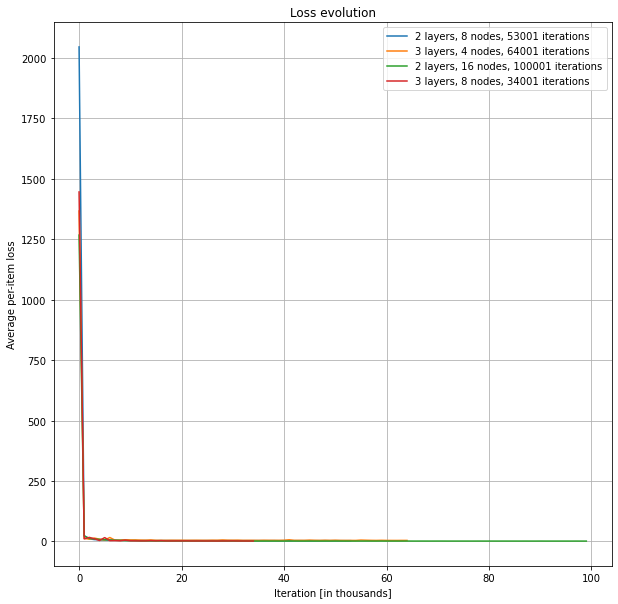

In [23]:
plt.figure(figsize=(10,10))
# plt.plot(losses)
plt.plot(earliest_stop1['losses'], label='2 layers, 8 nodes, {} iterations'.format(earliest_stop1['last_iter']))
plt.plot(earliest_stop2['losses'], label='3 layers, 4 nodes, {} iterations'.format(earliest_stop2['last_iter']))
plt.plot(earliest_stop3['losses'], label='2 layers, 16 nodes, {} iterations'.format(earliest_stop3['last_iter']))
plt.plot(earliest_stop4['losses'], label='3 layers, 8 nodes, {} iterations'.format(earliest_stop4['last_iter']))
plt.xlabel('Iteration [in thousands]')
plt.ylabel('Average per-item loss')
plt.title('Loss evolution')
plt.legend(loc='upper right')
plt.grid()
plt.show()

As you can see, the networks converges very well. Also, the values dosen't have big differences.<br>
So, the best one should be one that converges fastest. The 3 layer with 8 nodes each converges fastest.

# Bonus

In [26]:
numDataOne = 15
numData = numDataOne*numDataOne
# create data for regression
xs=np.linspace(-8,8,numDataOne)
ys=np.linspace(-8,8,numDataOne)
counter=0
X=np.zeros((numData,2))
y=np.zeros((numData,1))
for r in np.arange(0,numDataOne):
    for c in np.arange(0,numDataOne):
        X[counter,:]=[xs[r],ys[c]]
        # x^2+y^2+1
        y[counter]=xs[r]**2+ys[c]**2+1
        counter=counter+1
# training set size
num_examples = len(X) 
# output layer dimensionality
nn_output_dim = 1  
# learning rate for gradient descent
learning_rate = 1e-5
# regularization strength
reg_lambda = 0.01 
# activation function type
activation_function = 'relu'
# Number of hidden layers
hidden_layers_num = 4
# Number of hidden layer nodes
hidden_nodes_num = [8,16,8]
# sgd or not 
sgd = False
# regularization or not
regularization = False
# Number of iteration
epochs = 100000
regularization = False
model = create_model(X,hidden_nodes_num,nn_output_dim, 
                    activation_function, 
                    hidden_layers_num = hidden_layers_num)

# train it
model, losses, last_iter = train(model,X, y, 
                                epochs = epochs, 
                                reg_lambda=reg_lambda, 
                                learning_rate=learning_rate, 
                                hidden_layers_num=hidden_layers_num, 
                                sgd=sgd, 
                                regularization=regularization)

/tmp/ipykernel_2344/874329713.py:37: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs((previous_loss-loss)/previous_loss) < 0.0001:


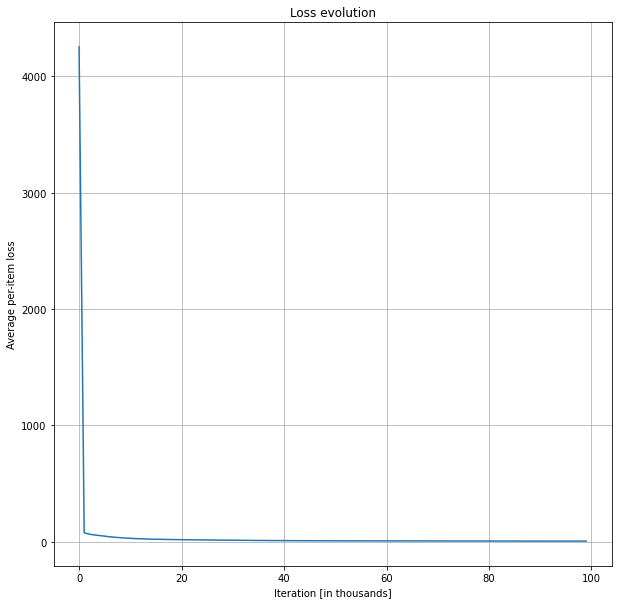

In [27]:
plt.figure(figsize=(10,10))
plt.plot(losses)
plt.xlabel('Iteration [in thousands]')
plt.ylabel('Average per-item loss')
plt.title('Loss evolution')
plt.grid()
plt.show()

For bonus, we choosed 4 layer for arbitary multi layer perceptron. <br>
The learning rate should be less then 1e-4. Becaouse it doesn not converge when the learning rate is larger than 1e-4.

# Part2

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from torchviz import make_dot

In [20]:
def experiment(x, y, config):
    # Getting the configuration from config dictionary
    input_dim = x.shape[1]
    output_dim = y.shape[1]
    learning_rate = config['learning_rate']
    activation_function = config['activation_function']
    hidden_nodes_num = config['hidden_nodes_num']
    opt = config['optimizer']
    epochs = config['epochs']
    device = config['device']
    
    if activation_function == "relu":
        activation_function = nn.ReLU()

    elif activation_function == "tanh":
        activation_function = nn.Tanh()

    elif activation_function == "logistic":
        activation_function = nn.LogSigmoid()
    
    else:
        print("Please enter a valid activation function")
        sys.exit()
        
    # Creating the model by using the config dictionary
    model = nn.Sequential(
        nn.Linear(input_dim, hidden_nodes_num[0]),
        activation_function,
        nn.Linear(hidden_nodes_num[0], hidden_nodes_num[1]),
        activation_function,
        nn.Linear(hidden_nodes_num[1], output_dim)
    )

    model.to(device)


    if opt == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    elif opt == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

    loss_func = nn.MSELoss(reduction="sum")
    loss_array = []

    tolerance = 0.0001

    previous_loss = float('inf')


    for i in range(epochs):
        # Forward pass: compute predicted y by passing x to the model. Module objects
        # override the __call__ operator so you can call them like functions. When
        # doing so you pass a Tensor of input data to the Module and it produces
        # a Tensor of output data.
        optimizer.zero_grad()
        y_pred = model(x) 
        
        # Compute and print loss. We pass Tensors containing the predicted and true
        # values of y, and the loss function returns a Tensor containing the loss.
        loss = loss_func(y_pred, y)
        loss.backward()

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the Tensors it will update (which are the learnable weights
        # of the model)
        optimizer.step()

        # Backward pass: compute gradient of the loss with respect to all the learnable
        # parameters of the model. Internally, the parameters of each Module are stored
        # in Tensors with requires_grad=True, so this call will compute gradients for
        # all learnable parameters in the model.
        loss_array.append(loss.item())

        if i % 1000 == 0:
            # calculate the loss
            current_loss = loss.item()
            # print("Loss after iteration %i: %f" %(i, loss))
            # very crude method to break optimization
            if np.abs((previous_loss-current_loss)/previous_loss) < tolerance:
                break
            previous_loss = current_loss

    return model, loss_array
        

In [11]:
numDataOne = 15
numData = numDataOne*numDataOne
# create data for regression
xs=np.linspace(-8,8,numDataOne)
ys=np.linspace(-8,8,numDataOne)
counter=0
X=np.zeros((numData,2))
y=np.zeros((numData,1))
for r in np.arange(0,numDataOne):
    for c in np.arange(0,numDataOne):
        X[counter,:]=[xs[r],ys[c]]
        # x^2+y^2+1
        y[counter]=xs[r]**2+ys[c]**2+1
        counter=counter+1

In [12]:
#if (torch.has_cuda): # do this for automatic switching
doGPU=True
if (doGPU):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [13]:
config1 = {}
config1['learning_rate'] = 0.001
config1['activation_function'] = "relu"
config1['hidden_nodes_num'] = [8,8]
config1['optimizer'] = "Adam"
config1['epochs'] = 100000
config1['device'] = device

In [14]:
config2 = {}
config2['learning_rate'] = 0.001
config2['activation_function'] = "relu"
config2['hidden_nodes_num'] = [8,8]
config2['optimizer'] = "SGD"
config2['epochs'] = 100000
config2['device'] = device

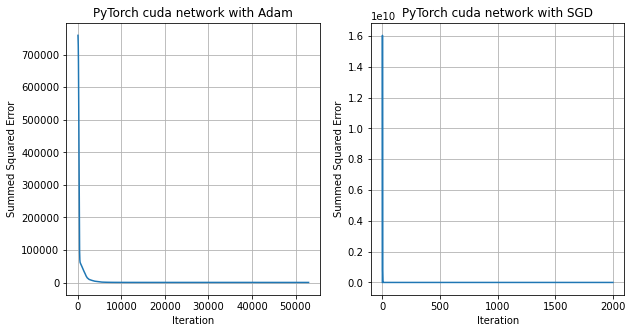

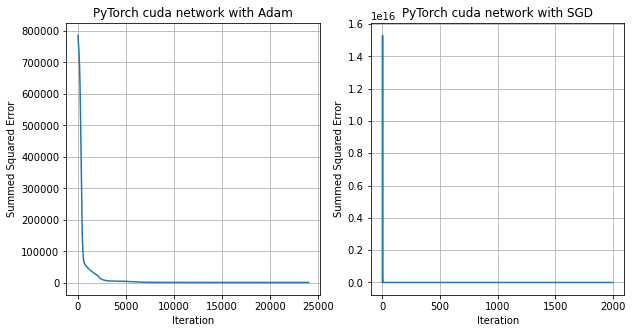

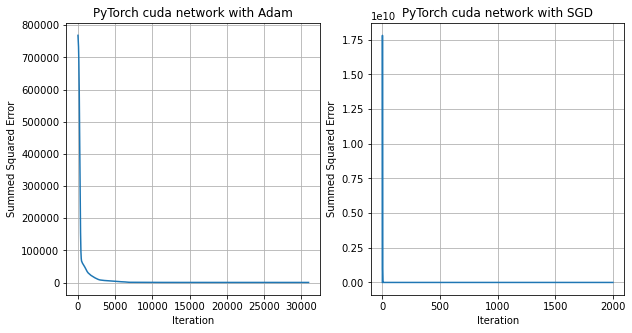

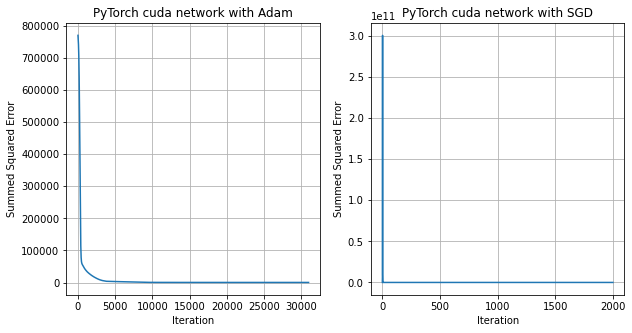

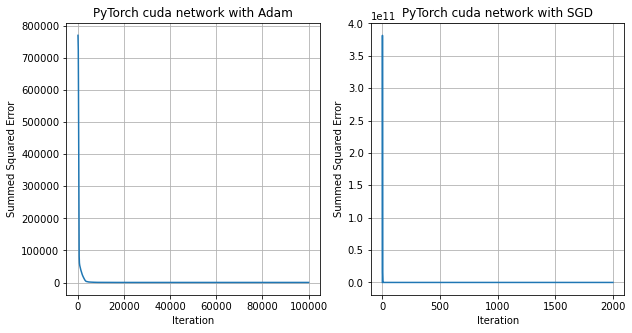

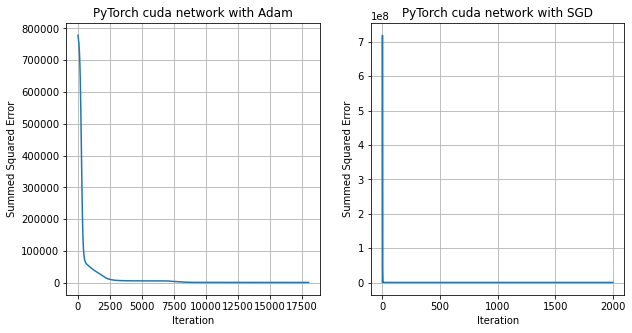

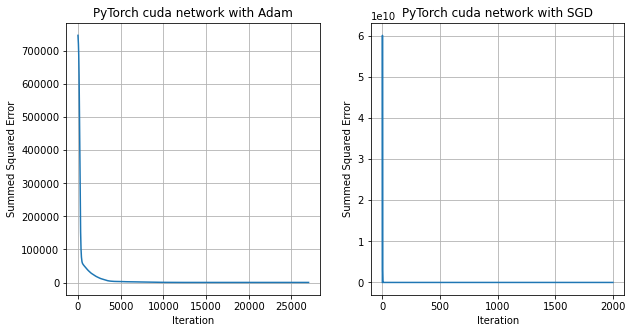

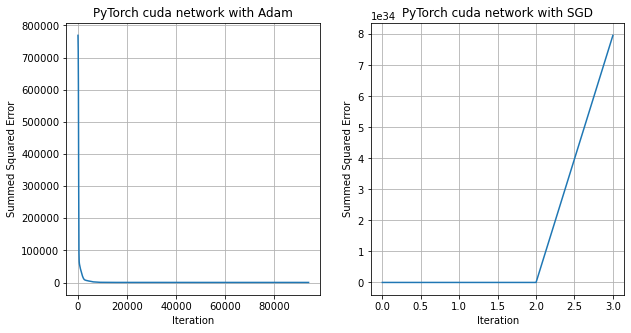

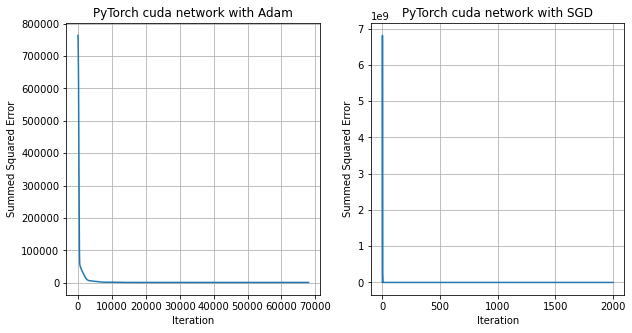

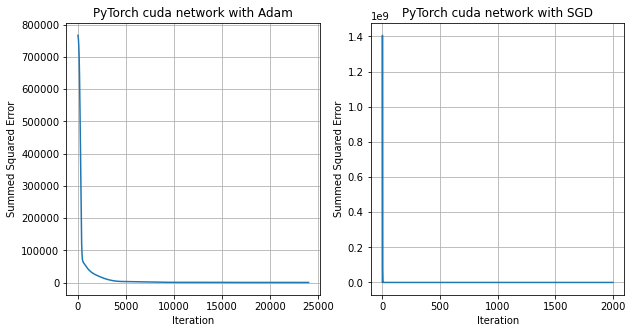

In [ ]:
result = {}
for i in range(10):
    model1, loss1 = experiment(torch.tensor(X).float().to(device), torch.tensor(y).float().to(device), config1)
    model2, loss2 = experiment(torch.tensor(X).float().to(device), torch.tensor(y).float().to(device), config2)

    fig,axes = plt.subplots(1,2,figsize=(10,5))
    axes[0].plot(loss1, label='optimzer: Adam')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Summed Squared Error')
    # axes[0].legend(loc='upper right')
    axes[0].set_title('PyTorch {0:} network with {1}'.format(device, 'Adam'))
    axes[0].grid()
    axes[1].plot(loss2, label='optimzer: SGD')
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Summed Squared Error')
    # axes[1].legend(loc='upper right')
    axes[1].set_title('PyTorch {0:} network with {1}'.format(device, 'SGD'))
    axes[1].grid()

    plt.show()

Most of the time sgd converges fast but adam optimzer is more stable.

In [ ]:
# if torchviz error occurs, please install graphviz or just load the images

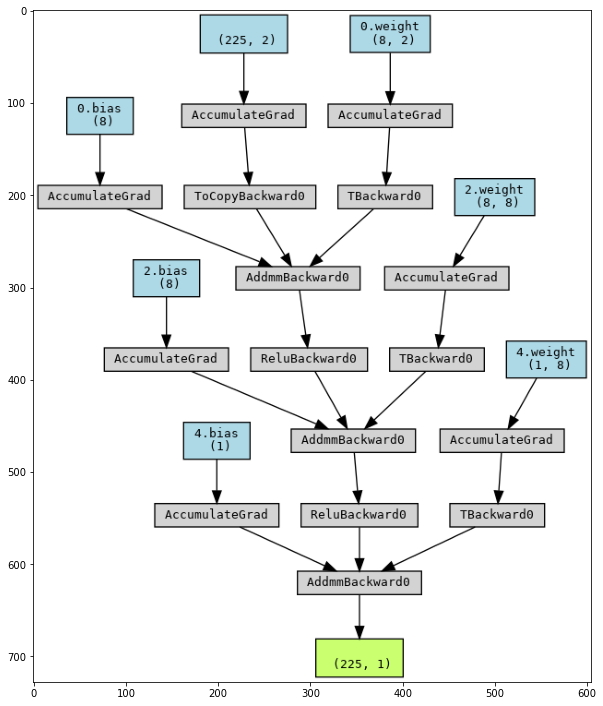

In [28]:
try:
    x = torch.tensor(X).float().requires_grad_(True).to(device)
    y = model1(x)
    make_dot(y, params=dict(list(model1.named_parameters()))).render("torchviz_adam", format="png")
    plt.figure(figsize=(10,20))
    img = mpimg.imread('torchviz_adam.png')
    plt.imshow(img)
    plt.show()

except:
    plt.figure(figsize=(10,20))
    img = mpimg.imread('torchviz_adam.png')
    plt.imshow(img)
    plt.show()

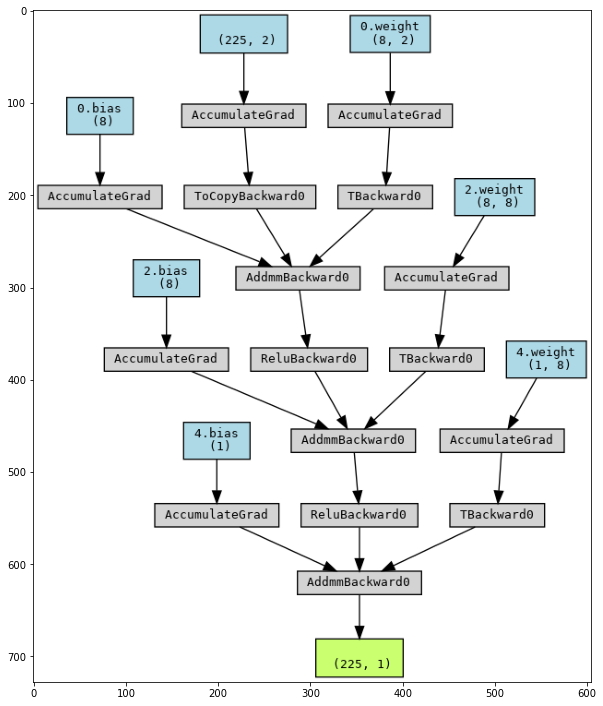

In [29]:
try:
    x = torch.tensor(X).float().requires_grad_(True).to(device)
    y = model2(x)
    make_dot(y, params=dict(list(model2.named_parameters()))).render("torchviz_sgd", format="png")
    plt.figure(figsize=(10,20))
    img = mpimg.imread('torchviz_sgd.png')
    plt.imshow(img)
    plt.show()

except:
    plt.figure(figsize=(10,20))
    img = mpimg.imread('torchviz_sgd.png')
    plt.imshow(img)
    plt.show()
